### Check CUDA installation

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [2]:
!nvidia-smi

Mon Sep 16 20:50:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              4W /   78W |      56MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Load Data sets

In [3]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-k_jdzhj1
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-k_jdzhj1
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done


In [4]:
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet32_train/"

#### Load Cifar-10

In [5]:
def load_batch(batchFile):
    f = open(PATH+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [6]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1")

In [7]:
CIFAR_CLASS_NAMES = load_classes()

In [8]:
CIFAR_IMAGES.shape

(10000, 3072)

#### Load ImageNet

In [9]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    return images, labels

In [10]:
IMAGENET_IMAGES, IMAGENET_LABELS = load_databatch(IMAGENET_PATH, 1)

In [11]:
IMAGENET_CLASS_NAMES(0)

'tench, Tinca tinca'

In [12]:
IMAGENET_IMAGES.shape

(128116, 3072)

### Prepare Kernels - Python POC

In [13]:
def scale_image_down_and_gray_1d(image, new_rows, new_cols):

    pixels = 1024
    newPixels = new_rows * new_cols;
    factor = pixels / newPixels;

    new_image = np.empty(newPixels, dtype=numpy.uint8)

    for idx in range(newPixels):
        pixelToTake = int(idx*factor)
        
        pixel = 0.2989 * image[pixelToTake] \
              + 0.5870 * image[1024+pixelToTake] \
              + 0.1140 * image[2048+pixelToTake]
        
        new_image[idx] = pixel
        
    return new_image

In [14]:
def scale_image_down_and_gray(np_image, new_rows, new_columns):
    
    columns = np_image.shape[0]
    rows = np_image.shape[1]

    factor_columns = columns / new_columns
    factor_rows = rows / new_rows

    new_image = np.empty([new_columns, new_rows, 1], dtype=numpy.uint8)

    print(new_image.shape)
    
    for row in range(new_rows):
        for col in range(new_columns):
            new_row = int(row * factor_rows)
            new_col = int(col * factor_columns)

            pixel = 0.2989 * np_image[new_col][new_row][0] \
                  + 0.5870 * np_image[new_col][new_row][1] \
                  + 0.1140 * np_image[new_col][new_row][2]
            
            new_image[col][row][0] = pixel
    return new_image

In [15]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

In [16]:
def comp_difference(image_2d):
    sequence = ""

    rows = image_2d.shape[0]
    cols = image_2d.shape[1]

    print( rows, cols )
    for row in range(rows):
        for col in range(1, cols):
            if image_2d[row][col-1] < image_2d[row][col]:
                sequence += '1'
            else:
                sequence += '0'

    print(sequence)

### CUDA kernes

#### Import PyCuda

In [17]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy

from pycuda.compiler import SourceModule

#### Convert 1000 images at once

In [18]:
mod = SourceModule("""

__global__ void ResizeAndGray1000Images(float* image, float* hash, const int pixels, const int new_rows, 
                                        const int new_cols, const int amountOfImages, const int hashSize)
{

    int idx           = threadIdx.x + blockIdx.x * blockDim.x;
    float newPixels   = new_rows * new_cols;
    int* pixelsValues = new int [new_rows * new_cols];
    
    if (idx > amountOfImages) return;

    float factor      = pixels / newPixels;
    int imageStartIdx = pixels * 3 * idx;
    
    for( int i=0; i<newPixels; i++ )
    {
        const auto pixelToTake = (int)(imageStartIdx+i*factor);
        pixelsValues[i] = 0.2989 * image[pixelToTake] + 0.5870 * image[1024+pixelToTake] + 0.1140 * image[2048+pixelToTake];
    }
    for( int i=1; i<newPixels; i++ )
    {
        pixelsValues[i-1] < pixelsValues[i] ? hash[hashSize*idx+i-1] = 1 : hash[hashSize*idx+i-1] = 0;
    }

    delete[] pixelsValues;
}

""")

ResizeAndGray1000Images = mod.get_function("ResizeAndGray1000Images")

#### Convert 1 image at once

In [19]:
mod = SourceModule("""

__global__ void ResizeAndGrayOneImage(float* image, float* hash, int pixels, int new_rows, int new_cols)
{
    extern __shared__ int pixelsValues[72];

    int idx         = threadIdx.x + blockIdx.x * blockDim.x;
    float newPixels = new_rows * new_cols;
    
    if (idx >= newPixels) return;

    float factor           = pixels / newPixels;
    const auto pixelToTake = (int)(idx*factor);


    auto pixel = 0.2989 * image[pixelToTake] + 0.5870 * image[1024+pixelToTake] + 0.1140 * image[2048+pixelToTake];

    pixelsValues[idx] = pixel;

    __syncthreads();
    
    if(idx == 0) return;

    pixelsValues[idx-1] < pixelsValues[idx] ? hash[idx-1] = 1 : hash[idx-1] = 0;    
}

""")

ResizeAndGrayOneImage = mod.get_function("ResizeAndGrayOneImage")

#### Convert CUDA output to human readable HEX Hash

In [20]:
def floatArrayToHexString(imageHashArray):
    hash_ = ""

    tmp_imageHashArray = imageHashArray.astype(numpy.uint8)

    
    for i in range(0, imageHashArray.shape[0], 4):
        tmp = str(tmp_imageHashArray[i]) + str(tmp_imageHashArray[i+1]) + str(tmp_imageHashArray[i+2]) + str(tmp_imageHashArray[i+3])
        
        hash_ += hex(int(tmp, 2))[2:]

    return hash_

#### Tests Kernels

In [23]:
HASH_SIZE = 64;

##### One Input Config

In [24]:
HASH_SIZE = 64;
THREADS_X = 64;
THREADS_Y = 1;
THREADS_Z = 1;

PIXELS = 1024
NEW_ROWS = 8
NEW_COLS = 9

INPUT_IMAGE = CIFAR_IMAGES[0].astype(numpy.float32)
OUT_HASH    = numpy.zeros([HASH_SIZE]).astype(numpy.float32)

In [25]:
ResizeAndGrayOneImage(drv.In(INPUT_IMAGE), drv.Out(OUT_HASH), np.int32(PIXELS) , np.int32(NEW_ROWS) , np.int32(NEW_COLS), 
            block=(THREADS_X, THREADS_Y, THREADS_Z))

In [26]:
floatArrayToHexString(OUT_HASH) # 63E3683A50325929

'dd599776ab5126b2'

##### 1000 Input Config

In [27]:
HASH_SIZE = 64;
THREADS_X_1000 = 1000;
THREADS_Y = 1;
THREADS_Z = 1;

PIXELS = 1024
NEW_ROWS = 8
NEW_COLS = 9

INPUT_IMAGE_1000 = CIFAR_IMAGES[:THREADS_X_1000].astype(numpy.float32).reshape(THREADS_X_1000 * PIXELS * 3)
OUT_HASH_1000    = numpy.zeros([THREADS_X_1000 * HASH_SIZE]).astype(numpy.float32)

In [28]:
ResizeAndGray1000Images(drv.In(INPUT_IMAGE_1000), drv.Out(OUT_HASH_1000), np.int32(PIXELS), 
                        np.int32(NEW_ROWS), np.int32(NEW_COLS), np.int32(THREADS_X_1000), np.int32(HASH_SIZE),
                        block=(THREADS_X_1000,THREADS_Y,THREADS_Z))

In [29]:
print(floatArrayToHexString(OUT_HASH_1000[0:64]))
print(floatArrayToHexString(OUT_HASH_1000[640:704]))
print(floatArrayToHexString(OUT_HASH_1000[6336:6400]))

dd599776ab5126b2
af52ad462a297695
9aadaa5ca956ac5a


#### Kernel Performance Tests

In [30]:
import time

In [31]:
start = time.time()

ResizeAndGray1000Images(drv.In(INPUT_IMAGE_1000), drv.Out(OUT_HASH_1000), np.int32(PIXELS), 
                        np.int32(NEW_ROWS), np.int32(NEW_COLS), np.int32(THREADS_X_1000), np.int32(HASH_SIZE),
                        block=(THREADS_X_1000,THREADS_Y,THREADS_Z))

end = time.time()
print( "time: ", end - start )

time:  0.0040738582611083984


In [32]:
start = time.time()

for i in range(1000):
    ResizeAndGrayOneImage(drv.In(INPUT_IMAGE), drv.Out(OUT_HASH), np.int32(PIXELS) , np.int32(NEW_ROWS) , np.int32(NEW_COLS), 
            block=(THREADS_X, THREADS_Y, THREADS_Z))
end = time.time()
print( "time: ", end - start )

time:  0.17073869705200195


#### Compare with other Libraries

In [31]:
#!pip install cupy-cuda12x

In [32]:
import numpy as np
import cupy as cp
import time
import torch
import torchvision.transforms as transforms

#### Compare with Torch

In [33]:
x0 = torch.randn(torch.Size([1000, 3, 32, 32]))
resize = transforms.Resize((9, 8), interpolation=transforms.InterpolationMode.BILINEAR)

In [41]:
torch.set_default_device("cpu")

start = time.time()
torch_resize_out = resize(x0)
end = time.time()
print( "time: ", end - start )

time:  0.003156900405883789


In [47]:
torch.set_default_device("cuda")

start = time.time()
torch_resize_out = resize(x0)
end = time.time()
print( "time: ", end - start )

time:  0.002462148666381836


#### Compare with Cupy

In [36]:
_on_gpu1 = cp.random.rand(3072000, dtype=np.float32)
on_gpu1_32 = cp.resize(_on_gpu1, (1000,3,32,32))

In [52]:
start = time.time()
on_gpu1_3 = cp.resize(on_gpu1_32, (1000,3,8,9))
end = time.time()
print(end - start)

0.001682281494140625


### CuLSH

In [33]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        idx = 0
        signature_1000 = numpy.zeros([1000 * 64]).astype(numpy.float32)
        for i in range(0, 10):
            INPUT_IMAGES = images[1000*i:1000*i+1000].astype(numpy.float32).reshape(1000 * 1024 * 3)
            ResizeAndGray1000Images(drv.In(INPUT_IMAGES), drv.Out(signature_1000), np.int32(1024), 
                        np.int32(8), np.int32(9), np.int32(1000), np.int32(64),
                        block=(1000,1,1))
            
            signature_ = signature_1000.astype(numpy.bool_)

            for j in range(0, 1000):
                one_signature = signature_[64*j:64*j+64]
                self.signatures[idx] = np.packbits(one_signature)
                self.fill_buckets(one_signature, idx)
                idx += 1

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [41]:
lsh = LSH(8, 8)

start = time.time()
lsh.compute_hash(CIFAR_IMAGES)
print( "time: ", time.time() - start )

start = time.time()
pairs = lsh.compute_candidate()
print( "time: ", time.time() - start )

start = time.time()
duplicates = lsh.check_candidate(pairs,0.9)
print( "time: ", time.time() - start )


time:  0.12008905410766602
time:  5.203833341598511
time:  125.68330907821655


In [42]:
print( len(CIFAR_IMAGES) )
print( len(pairs) )
print( len(duplicates) )

10000
8516493
1066


#### Kernel with interpolation

In [43]:
# https://annmay10.medium.com/resizing-images-using-various-interpolation-techniques-4b99800999f2
# https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html

# https://stackoverflow.com/questions/26089893/understanding-numpys-einsum

In [44]:
mod = SourceModule("""

#include <cmath>

__global__ void ResizeAndGray1000ImagesInterpoted(float* image, float* hash, const int pixels, const int new_rows, 
                                        const int new_cols, const int amountOfImages, const int hashSize)
{

    int idx           = threadIdx.x + blockIdx.x * blockDim.x;

    float xRatio = pixels / new_cols;
    float yRatio = pixels / new_rows;

    if ( xRatio < yRatio ) xRatio = yRatio;
    
    if (idx > amountOfImages) return;

    int imageStartIdx = pixels * pixels * 3 * idx;

    int new_pixels = new_rows * new_cols;
    
    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=0; j<new_cols; j++)
        {
            float xPixel = i*yRatio;
            float yPixel = j*xRatio;

            const int x_l = floor(xPixel);  // x lower
            const int y_l = floor(yPixel);
            const int x_h = ceil(xPixel);   // x higher
            const int y_h = ceil(yPixel);

            const float x_weight = xPixel - x_l;
            const float y_weight = yPixel - y_l;

            const int pixelToTakeA = imageStartIdx + x_l * 32 + y_l;
            const int pixelToTakeB = imageStartIdx + x_h * 32 + y_l;
            const int pixelToTakeC = imageStartIdx + x_l * 32 + y_h;
            const int pixelToTakeD = imageStartIdx + x_h * 32 + y_h;
            
            const float a = 0.2989 * image[pixelToTakeA] + 0.5870 * image[1024+pixelToTakeA] + 0.1140 * image[2048+pixelToTakeA];
            const float b = 0.2989 * image[pixelToTakeB] + 0.5870 * image[1024+pixelToTakeB] + 0.1140 * image[2048+pixelToTakeB];
            const float c = 0.2989 * image[pixelToTakeC] + 0.5870 * image[1024+pixelToTakeC] + 0.1140 * image[2048+pixelToTakeC];
            const float d = 0.2989 * image[pixelToTakeD] + 0.5870 * image[1024+pixelToTakeD] + 0.1140 * image[2048+pixelToTakeD];

            const float pixel = a * (1 - x_weight) * (1 - y_weight) 
              + b * x_weight * (1 - y_weight) +
              c * y_weight * (1 - x_weight) +
              d * x_weight * y_weight;
              
            hash[new_pixels * idx + i * new_cols + j ] = pixel;
        }
    }
}

""")

ResizeAndGray1000ImagesInterpoted = mod.get_function("ResizeAndGray1000ImagesInterpoted")

In [45]:
mod = SourceModule("""

#include <cmath>

__global__ void ResizeAndGray1000ImagesInterpotedHash(float* image, float* hash, const int pixels, const int new_rows, 
                                        const int new_cols, const int amountOfImages, const int hashSize)
{

    int idx           = threadIdx.x + blockIdx.x * blockDim.x;
    float* pixelsValues = new float [new_rows * new_cols];

    const float originImageSize = 32;
    float xRatio = originImageSize / new_cols;
    float yRatio = originImageSize / new_rows;

    if ( xRatio < yRatio ) xRatio = yRatio;
    
    if (idx > amountOfImages) return;

    int imageStartIdx = pixels * pixels * 3 * idx;
    
    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=0; j<new_cols; j++)
        {
            float xPixel = i*yRatio;
            float yPixel = j*xRatio;

            const int x_l = floor(xPixel);  // x lower
            const int y_l = floor(yPixel);
            const int x_h = ceil(xPixel);   // x higher
            const int y_h = ceil(yPixel);

            const float x_weight = xPixel - x_l;
            const float y_weight = yPixel - y_l;

            const int pixelToTakeA = imageStartIdx + x_l * 32 + y_l;
            const int pixelToTakeB = imageStartIdx + x_h * 32 + y_l;
            const int pixelToTakeC = imageStartIdx + x_l * 32 + y_h;
            const int pixelToTakeD = imageStartIdx + x_h * 32 + y_h;
            
            const float a = 0.2989 * image[pixelToTakeA] + 0.5870 * image[1024+pixelToTakeA] + 0.1140 * image[2048+pixelToTakeA];
            const float b = 0.2989 * image[pixelToTakeB] + 0.5870 * image[1024+pixelToTakeB] + 0.1140 * image[2048+pixelToTakeB];
            const float c = 0.2989 * image[pixelToTakeC] + 0.5870 * image[1024+pixelToTakeC] + 0.1140 * image[2048+pixelToTakeC];
            const float d = 0.2989 * image[pixelToTakeD] + 0.5870 * image[1024+pixelToTakeD] + 0.1140 * image[2048+pixelToTakeD];

            const float pixel = a * (1 - x_weight) * (1 - y_weight) 
              + b * x_weight * (1 - y_weight) +
              c * y_weight * (1 - x_weight) +
              d * x_weight * y_weight;
              
            pixelsValues[i * new_rows + j ] = pixel;
        }
    }

    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=1; j<new_cols; j++)
        {
            pixelsValues[i*new_rows+j-1] < pixelsValues[i*new_rows+j] ? 
                hash[hashSize*idx+i*new_rows+j-1] = 1 : hash[hashSize*idx+i*new_rows+j-1] = 0;
        }
    }

    delete pixelsValues;

    __syncthreads();
}

""")

ResizeAndGray1000ImagesInterpotedHash = mod.get_function("ResizeAndGray1000ImagesInterpotedHash")

In [46]:
THREADS_X_1000 = 1000;
THREADS_Y = 1;
THREADS_Z = 1;

ROWS = 32
COLUMNS = 32

NEW_ROWS = 16
NEW_COLS = 16

HASH_SIZE = NEW_ROWS * NEW_COLS

INPUT_IMAGE_1000 = CIFAR_IMAGES[:THREADS_X_1000].astype(numpy.float32).reshape(THREADS_X_1000 * ROWS * COLUMNS * 3)
OUT_HASH_1000    = numpy.zeros([THREADS_X_1000 * HASH_SIZE]).astype(numpy.float32)

In [47]:
print(INPUT_IMAGE_1000.shape)
print(OUT_HASH_1000.shape)

(3072000,)
(256000,)


In [48]:
ResizeAndGray1000ImagesInterpoted(drv.In(INPUT_IMAGE_1000), drv.Out(OUT_HASH_1000), np.int32(ROWS), 
                        np.int32(NEW_ROWS), np.int32(NEW_COLS), np.int32(THREADS_X_1000), np.int32(HASH_SIZE),
                        block=(THREADS_X_1000,THREADS_Y,THREADS_Z))

In [49]:
imageP = OUT_HASH_1000[0:256].reshape(1,16,16)

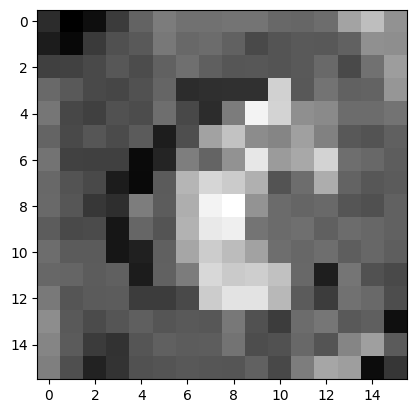

In [50]:
from matplotlib import pyplot as plt
plt.imshow(imageP.T, interpolation='nearest', cmap='gray')
plt.show()

In [51]:
THREADS_X_1000 = 1000;
THREADS_Y = 1;
THREADS_Z = 1;

ROWS = 32
COLUMNS = 32

NEW_ROWS = 16
NEW_COLS = 17 # always + 1

HASH_SIZE = NEW_ROWS * (NEW_COLS-1)

INPUT_IMAGE_1000 = CIFAR_IMAGES[:THREADS_X_1000].astype(numpy.float32).reshape(THREADS_X_1000 * ROWS * COLUMNS * 3)
OUT_HASH_1000    = numpy.zeros([THREADS_X_1000 * HASH_SIZE]).astype(numpy.float32)

In [52]:
import time
start = time.time()

ResizeAndGray1000ImagesInterpotedHash(drv.In(INPUT_IMAGE_1000), drv.Out(OUT_HASH_1000), np.int32(ROWS), 
                        np.int32(NEW_ROWS), np.int32(NEW_COLS), np.int32(THREADS_X_1000), np.int32(HASH_SIZE),
                        block=(THREADS_X_1000,THREADS_Y,THREADS_Z))
end = time.time()
print( "time: ", end - start )

time:  0.02460479736328125


In [53]:
print(floatArrayToHexString(OUT_HASH_1000[0:64]))
print(floatArrayToHexString(OUT_HASH_1000[640:704]))
print(floatArrayToHexString(OUT_HASH_1000[6336:6400]))

7558eb6ccae1d123
85cd2d07169f12df
d893ead9b27c9c39


#### Experiments with CUDA LSH

In [54]:
# Cache w pamieciu GPU danych zrobic
# https://stackoverflow.com/questions/39445786/how-to-define-cuda-device-constant-like-a-c-const-constexpr
# Whats about Torch resize kernel ???? - comparision
# whats about numpy on gpu ????? - comparision
# Zgrać zdjecia i porownac jak radzi sobie w sytuacji zycia codziennego !!
# Zdjecia z poza setu jak sobie radzi - dHash i NeuralNetwork
# https://stackoverflow.com/questions/30261859/using-dictionary-in-pycuda
#
# Brak wsparcia Algorithm i functional oraz dyrektyw z extern "C"

# optymalizacja memory jest ale jeszcze jakas bardziej customowa
# operacji na bitach nawet nie mozna normalnie zrobic
# https://forums.developer.nvidia.com/t/pycuda-thrust-example-in-case-someone-is-curious/17795

In [158]:
mod = SourceModule("""

__global__ void ComparePairs(float* pairs, float* signatures, float* res, float threshold, float hash_size, int pairsElements)
{
    unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;

    if(x > pairsElements) return;

    const int bitsNumbers = hash_size * hash_size / 8;
    const int imageIdx1 = pairs[x*2];
    const int imageIdx2 = pairs[x*2+1];
    unsigned int hammingDistance = 0;
    
    for(int i=0; i<bitsNumbers; i++)
    {
        unsigned int common = (unsigned int)signatures[imageIdx1*bitsNumbers+i] ^ (unsigned int)signatures[imageIdx2*bitsNumbers+i];

         while ( common>0 )
         {
            unsigned int val = common&1;
            common>>=1;
            hammingDistance += val;
        }
    }

    float similarity = (hash_size * hash_size - hammingDistance) / ( hash_size * hash_size );

    if ( similarity >= threshold )
    {
        res[x] = similarity;
    }
}

""")

ComparePairs = mod.get_function("ComparePairs")

In [159]:
#pairs = numpy.zeros([3]).astype(numpy.float32)
#pairs[0] = 7
#pairs[1] = 2

#res = numpy.zeros([2]).astype(numpy.float32)

#ComparePairs(drv.In(pairs), drv.Out(res), np.float32(0.9), np.int8(16), block=(1000,1,1), grid=(500,1,1))

#ComparePairs(drv.In(pairs), drv.In(self.signatures), drv.Out(resSimilarity), 
#                         np.float32(threshold), np.int8(self.hash_size), np.int32(len(pairs)),
#                         block=(1000,1,1), grid=(500,1,1))


#print(pairs)
#print(res)
#print(int(pairs[0]) ^ int(pairs[1]))

In [197]:
from typing import List, Dict, Tuple

class LSH:
    def __init__(self, size, hash_size, images):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = numpy.zeros([len(images), hash_size // 8 * hash_size]).astype(numpy.float32)
        self.hash_size = hash_size
        self.images = images;

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self):
        idx = 0
        IMAGES_AT_ONCE = 1000;
        for i in range(0, len(self.images) // IMAGES_AT_ONCE):
            signature_1000 = numpy.zeros([IMAGES_AT_ONCE * self.hash_size**2 ]).astype(numpy.float32)
            INPUT_IMAGES = self.images[IMAGES_AT_ONCE*i:IMAGES_AT_ONCE*i+IMAGES_AT_ONCE].astype(numpy.float32).reshape(IMAGES_AT_ONCE * 1024 * 3)
            ResizeAndGray1000ImagesInterpotedHash(drv.In(INPUT_IMAGES), drv.Out(signature_1000), np.int32(32), 
                        np.int32(self.hash_size), np.int32(self.hash_size+1), np.int32(IMAGES_AT_ONCE), np.int32(self.hash_size**2),
                        block=(IMAGES_AT_ONCE,1,1))

            for j in range(0, IMAGES_AT_ONCE):
                one_signature = signature_1000[self.hash_size**2 * j: self.hash_size**2 * j+ self.hash_size**2]
                self.signatures[idx] = np.packbits(one_signature.astype(np.int8)).astype(np.float32)
                #self.signatures[idx] = one_signature.astype(np.int8)
                self.fill_buckets(one_signature, idx)
                idx += 1

    def compute_candidate(self):
        candidate_pairs = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.append(hash_bucket[i])
                            candidate_pairs.append(hash_bucket[j])
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        pairsNumpy = numpy.asarray(candidate_pairs, dtype=np.float32)
        signaturesReshaped = self.signatures.reshape(-1)

        print(pairsNumpy.shape)
        
        for i in range(0, pairsNumpy.shape[0], 1000000):
            resSimilarity = numpy.zeros([500000]).astype(numpy.float32)
            inTable = pairsNumpy[0+i:1000000+i]
            ComparePairs(drv.In(inTable), drv.In(signaturesReshaped), drv.Out(resSimilarity), 
                         np.float32(threshold), np.float32(self.hash_size), np.int32(inTable.shape[0]//2),
                         block=(1000,1,1), grid=(500,1,1))

            for j in range(0, len(resSimilarity)):
                if resSimilarity[j] != 0:
                    near_duplicates.append((pairsNumpy[j*2], pairsNumpy[j*2+1], resSimilarity[j]))

        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [198]:
start = time.time()
lsh = LSH(8, 8, CIFAR_IMAGES)
print( "time: ", time.time() - start )

start = time.time()
lsh.compute_hash()
print( "time: ", time.time() - start )

start = time.time()
pairs = lsh.compute_candidate()
print( "time: ", time.time() - start )


time:  0.0009067058563232422
time:  0.15226173400878906
time:  0.20795917510986328


In [199]:
len(pairs) # zamineic na rozpakowane bity / skalowanie

3883906

In [200]:
start = time.time()
duplicates = lsh.check_candidate(pairs,0.9)
end = time.time()
print( "time: ", end - start )

(3883906,)
time:  3.2410073280334473


In [201]:
print( len(duplicates) )
print( duplicates[0][0] )
#for i in range(0, len(duplicates)):
#    if duplicates[i] != 0:
#        print(duplicates[i])

62
1200.0


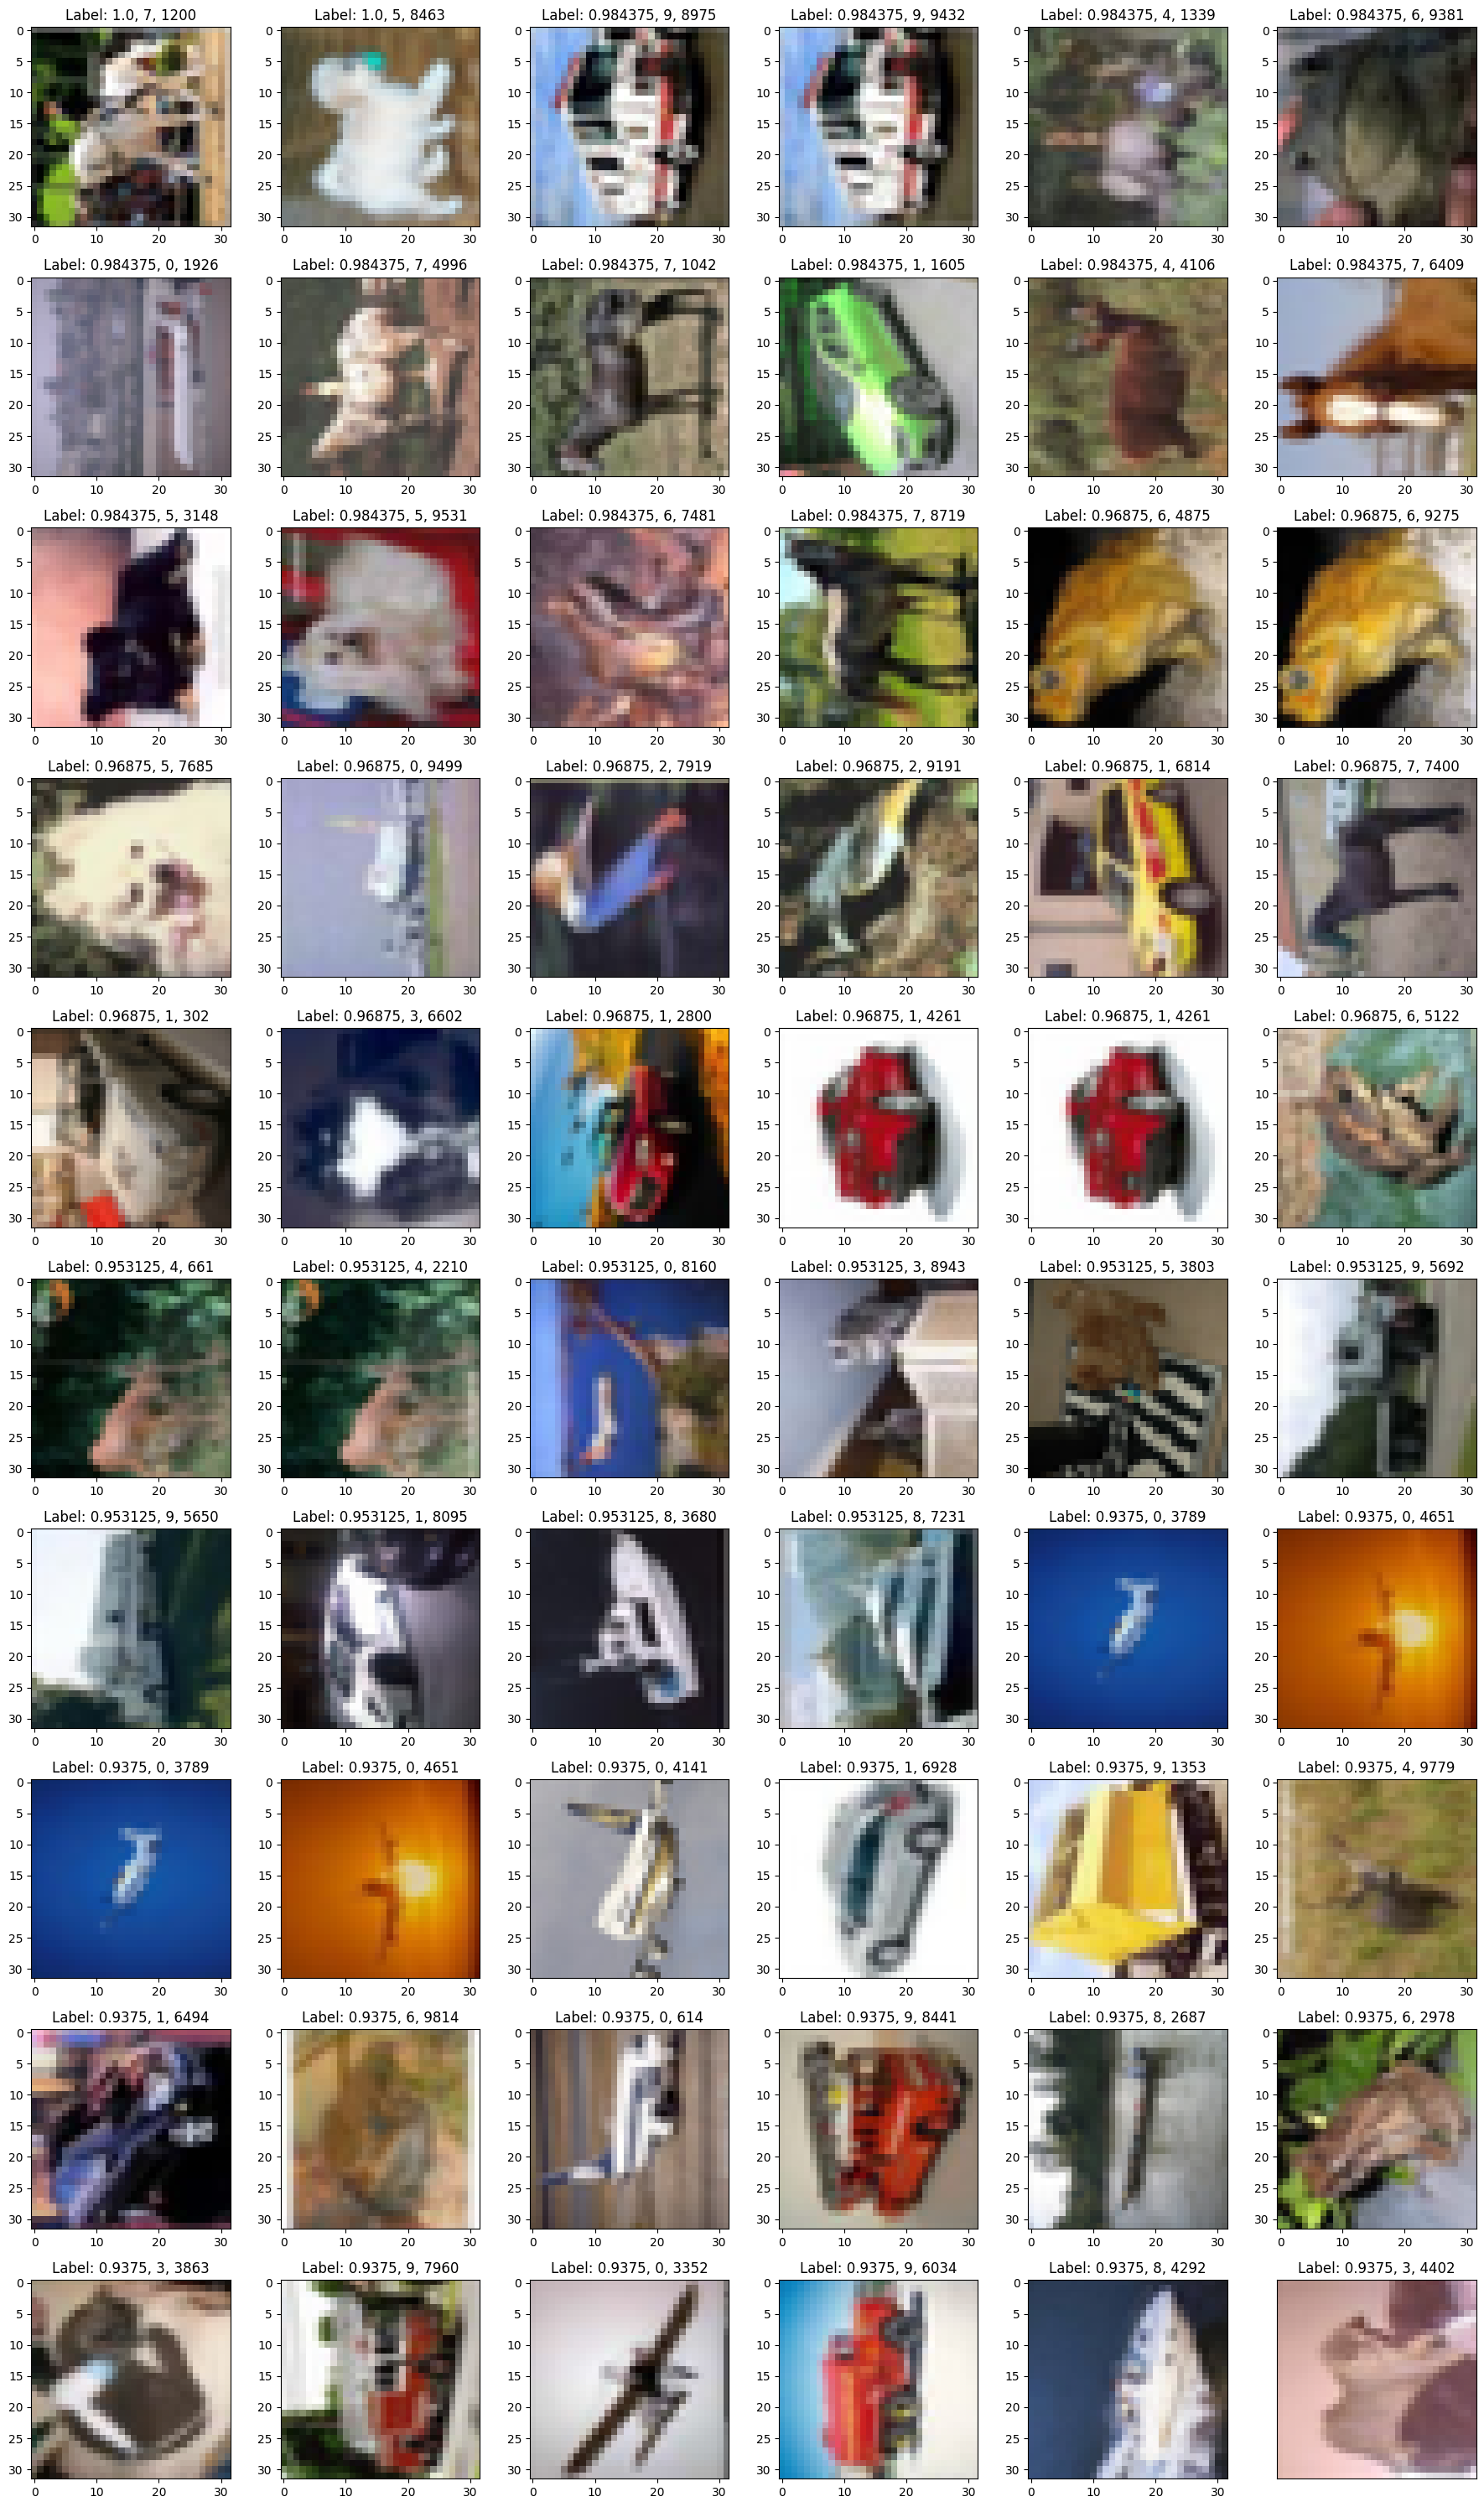

In [202]:
from matplotlib import pyplot as plt

num_row = 10
num_col = 6

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col, 2):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(CIFAR_IMAGES[int(duplicates[i//2 + idx_start][0])].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates[i//2 + idx_start][2]}, {CIFAR_LABELS[int(duplicates[i//2 + idx_start][0])]}, {int(duplicates[i//2 + idx_start][0])}""")

    ax = axes[(i+1)//num_col, (i+1)%num_col]
    ax.imshow(CIFAR_IMAGES[int(duplicates[i//2 + idx_start][1])].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates[i//2 + idx_start][2]}, {CIFAR_LABELS[int(duplicates[i//2 + idx_start][1])]}, {int(duplicates[i//2 + idx_start][1])}""")


plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

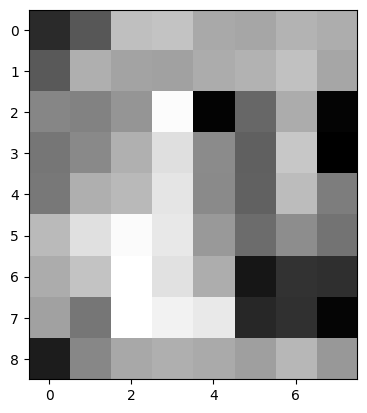

In [156]:
INPUT_IMAGE_1 = CIFAR_IMAGES[206].astype(numpy.float32).reshape(1 * ROWS * COLUMNS * 3)
OUT_HASH_1    = numpy.zeros([1 * 72]).astype(numpy.float32)

ResizeAndGray1000ImagesInterpoted(drv.In(INPUT_IMAGE_1), drv.Out(OUT_HASH_1), np.int32(32), 
                        np.int32(8), np.int32(9), np.int32(1), np.int32(72),
                        block=(1,1,1))

plt.imshow(OUT_HASH_1.reshape(1,8,9).T, interpolation='nearest', cmap='grey')
plt.show()

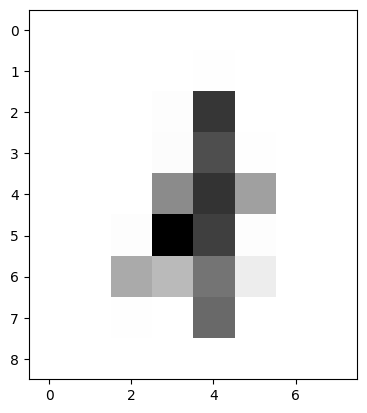

In [157]:
INPUT_IMAGE_1 = CIFAR_IMAGES[9181].astype(numpy.float32).reshape(1 * ROWS * COLUMNS * 3)
OUT_HASH_1    = numpy.zeros([1 * 72]).astype(numpy.float32)

ResizeAndGray1000ImagesInterpoted(drv.In(INPUT_IMAGE_1), drv.Out(OUT_HASH_1), np.int32(32), 
                        np.int32(8), np.int32(9), np.int32(1), np.int32(72),
                        block=(1,1,1))

plt.imshow(OUT_HASH_1.reshape(1,8,9).T, interpolation='nearest', cmap='grey')
plt.show()

In [277]:
# Wnioski z wynikow i testow
# no do 0.7 sa podobne, ale tez i bezsensowne duplikaty......